# The KDD process :

1. Selection: Identifying the target dataset.
2. Preprocessing: Cleaning, transforming, and enriching the data.
3. Transformation: Getting the data into the right form or structure.
4. Data Mining: Applying algorithms to extract patterns.
5. Interpretation/Evaluation: Analyzing the patterns and turning them into knowledge.
6. Deployment: Implementing the results into the organization's operations.

In [3]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/Sem-I/CMPE-255 Data Mining/Assignments3/KDD/Amazon_popular_books_dataset.csv'

Mounted at /content/gdrive


# Phase 1: Selection

In [4]:
import pandas as pd

# Load the dataset
amazon_books_df = pd.read_csv(file_path)

# Display the first few rows
amazon_books_df.head()

,asin,ISBN10,answered_questions,availability,brand,currency,date_first_available,delivery,department,description,...,upc,url,video,video_count,categories,best_sellers_rank,buybox_seller,image,number_of_sellers,colors
0,0007350813,0007350813,0,In Stock.,Emily Brontë,USD,NaN,"[""FREE delivery Tuesday, December 28 if you sp...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0007350813,NaN,0,"[""Books"",""Literature & Fiction"",""Genre Fiction""]","[{""category"":""Books / Literature & Fiction / H...",NaN,NaN,NaN,NaN
1,0007513763,9780007513765,0,In Stock.,Drew Daywalt,USD,NaN,"[""FREE delivery Tuesday, December 28 if you sp...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0007513763,NaN,0,"[""Books"",""Children's Books"",""Literature & Fict...","[{""category"":""Books / Children's Books / Liter...",VMG Books & Media,NaN,NaN,NaN
2,0008183988,0008183988,0,NaN,Bernard Cornwell,USD,NaN,"[""FREE delivery January 4 - 10 if you spend $2...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0008183988,NaN,0,"[""Books"",""Literature & Fiction"",""Genre Fiction""]","[{""category"":""Books / Literature & Fiction / H...",Reuseaworld,NaN,NaN,NaN
3,0008305838,0008305838,0,In Stock.,David Walliams,USD,NaN,"[""FREE delivery Tuesday, December 28 if you sp...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0008305838,NaN,0,"[""Books"",""Children's Books"",""Literature & Fict...","[{""category"":""Books / Children's Books / Liter...",Bahamut Media,NaN,NaN,NaN
4,0008375526,0008375526,0,In Stock.,Caroline Hirons,USD,NaN,"[""FREE delivery Tuesday, December 28"",""Or fast...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0008375526,NaN,0,"[""Books"",""Crafts, Hobbies & Home"",""Home Improv...","[{""category"":""Books / Health, Fitness & Dietin...",KathrynAshleyGallery,NaN,NaN,NaN


# Phase 2: Preprocessing

In [5]:
# Check for missing values in each column
missing_values = amazon_books_df.isnull().sum()

# Percentage of missing values
missing_percentage = (missing_values / len(amazon_books_df)) * 100

# Combine the data into a dataframe for a better view
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})

# Display columns with missing values
missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)


,Missing Values,Percentage (%)
department,2269,100.000000
upc,2269,100.000000
video,2268,99.955928
colors,2267,99.911855
date_first_available,2266,99.867783
model_number,2265,99.823711
number_of_sellers,2265,99.823711
image,2265,99.823711
manufacturer,2265,99.823711
description,1557,68.620538


- Drop columns with more than 90% missing values as they are unlikely to provide significant insights.
- For categorical columns with missing values, we can replace the missing values with a placeholder like "Unknown" or use the mode (most frequent value) of that column.
- For numerical columns with missing values, we can replace the missing values with the median or mean of that column.

In [6]:
# Drop columns with more than 90% missing values
columns_to_drop = missing_df[missing_df['Percentage (%)'] > 90].index
amazon_books_df = amazon_books_df.drop(columns=columns_to_drop)

# Display the shape of the dataframe after dropping columns
amazon_books_df.shape


(2269, 31)

- For categorical columns, we'll replace missing values with the placeholder "Unknown".
- For numerical columns, we'll replace missing values with the median of that column (since the median is less sensitive to outliers).

In [7]:
# Identify categorical and numerical columns
categorical_columns = amazon_books_df.select_dtypes(include=['object']).columns
numerical_columns = amazon_books_df.select_dtypes(exclude=['object']).columns

# Replace missing values
for column in categorical_columns:
    amazon_books_df[column].fillna('Unknown', inplace=True)

for column in numerical_columns:
    median_value = amazon_books_df[column].median()
    amazon_books_df[column].fillna(median_value, inplace=True)

# Check if there are any missing values left
remaining_missing = amazon_books_df.isnull().sum().sum()
remaining_missing


0

 Identifying and Handling Outliers

In [8]:
# Function to detect outliers using IQR
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]

# Detect outliers for numerical columns
outliers_data = {}
for column in numerical_columns:
    outliers = detect_outliers(amazon_books_df, column)
    outliers_data[column] = len(outliers)

# Display the count of outliers for each numerical column
outliers_data


{'answered_questions': 4,
 'discount': 991,
 'final_price': 369,
 'images_count': 92,
 'initial_price': 1071,
 'plus_content': 0,
 'reviews_count': 191,
 'root_bs_rank': 308,
 'video_count': 1}

Convert Data Types (if necessary)

In [9]:
# Check data types of the columns
data_types = amazon_books_df.dtypes
data_types


asin                   object
ISBN10                 object
answered_questions      int64
availability           object
brand                  object
currency               object
delivery               object
description            object
discount              float64
domain                 object
features               object
final_price           float64
format                 object
image_url              object
images_count            int64
initial_price         float64
item_weight            object
plus_content          float64
product_dimensions     object
rating                 object
reviews_count           int64
root_bs_rank          float64
seller_id              object
seller_name            object
timestamp              object
title                  object
url                    object
video_count             int64
categories             object
best_sellers_rank      object
buybox_seller          object
dtype: object

In [10]:
# Convert the 'rating' column to numerical format by extracting the numeric value
amazon_books_df['rating'] = amazon_books_df['rating'].str.extract('(\d+\.\d+)').astype(float)

# Convert the 'timestamp' column to datetime format
amazon_books_df['timestamp'] = pd.to_datetime(amazon_books_df['timestamp'])

# Check the data types again to confirm the changes
updated_data_types = amazon_books_df[['rating', 'timestamp']].dtypes
updated_data_types


rating                   float64
timestamp    datetime64[ns, UTC]
dtype: object

# Phase 3: Transformation
3.1 Feature Engineering
**bold text**
A couple of potential features to derive:
- From the categories column, we can extract the primary category for each book.
- From the delivery column, we can extract whether free delivery is available.

In [11]:
# Extract primary category from the 'categories' column
amazon_books_df['primary_category'] = amazon_books_df['categories'].str.extract(r'\"(.*?)\"')

# Extract information about free delivery from the 'delivery' column
amazon_books_df['free_delivery'] = amazon_books_df['delivery'].str.contains('FREE delivery', case=False).astype(int)

# Display the first few rows to check the new features
amazon_books_df[['primary_category', 'free_delivery']].head()


,primary_category,free_delivery
0,Books,1
1,Books,1
2,Books,1
3,Books,1
4,Books,1


# Phase 4: Data Mining

Let's start with some descriptive statistics for our numerical columns.



In [12]:
# Descriptive statistics for numerical columns
descriptive_stats = amazon_books_df.describe(include=[float, int])
descriptive_stats


,answered_questions,discount,final_price,images_count,initial_price,plus_content,rating,reviews_count,root_bs_rank,video_count,free_delivery
count,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.0,2269.000000,2269.000000,2.269000e+03,2269.000000,2269.000000
mean,0.034376,7.436007,12.848561,2.093874,19.943169,1.0,4.622345,21497.738211,3.085359e+04,0.000881,0.620978
std,1.244976,7.395791,6.391372,2.955207,11.310705,0.0,0.192836,16108.019322,1.253451e+05,0.041987,0.485250
min,0.000000,0.500000,1.990000,0.000000,3.490000,1.0,3.400000,10010.000000,1.000000e+00,0.000000,0.000000
25%,0.000000,6.410000,10.700000,0.000000,17.990000,1.0,4.500000,12393.000000,8.190000e+02,0.000000,0.000000
50%,0.000000,6.610000,12.005000,1.000000,17.990000,1.0,4.700000,16119.000000,3.104000e+03,0.000000,1.000000
75%,0.000000,6.800000,13.580000,3.000000,18.000000,1.0,4.800000,23817.000000,1.472400e+04,0.000000,1.000000
max,58.000000,282.490000,132.990000,52.000000,299.000000,1.0,4.900000,196572.000000,2.904335e+06,2.000000,1.000000


Let's start with the distribution of book ratings.

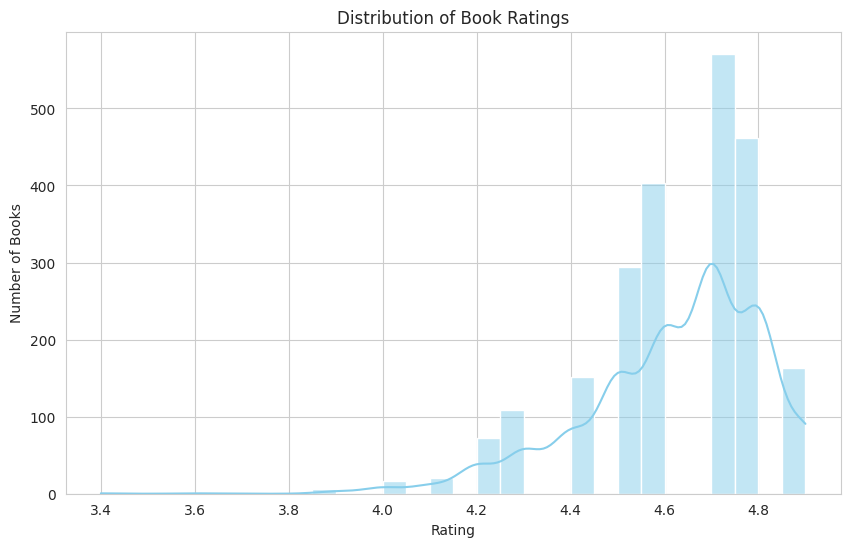

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set_style("whitegrid")

# Plot the distribution of book ratings
plt.figure(figsize=(10, 6))
sns.histplot(amazon_books_df['rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Books')
plt.show()


let's visualize the distribution of final book prices.

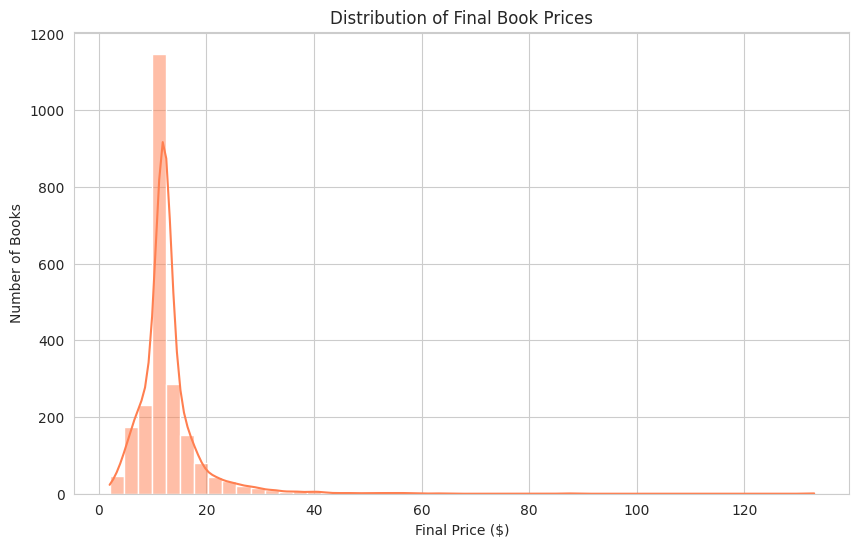

In [14]:
# Plot the distribution of final book prices
plt.figure(figsize=(10, 6))
sns.histplot(amazon_books_df['final_price'], bins=50, kde=True, color='coral')
plt.title('Distribution of Final Book Prices')
plt.xlabel('Final Price ($)')
plt.ylabel('Number of Books')
plt.show()


 let's explore the relationship between book ratings and the number of reviews to see if more highly-rated books tend to get more reviews. We'll use a scatter plot for this visualization.

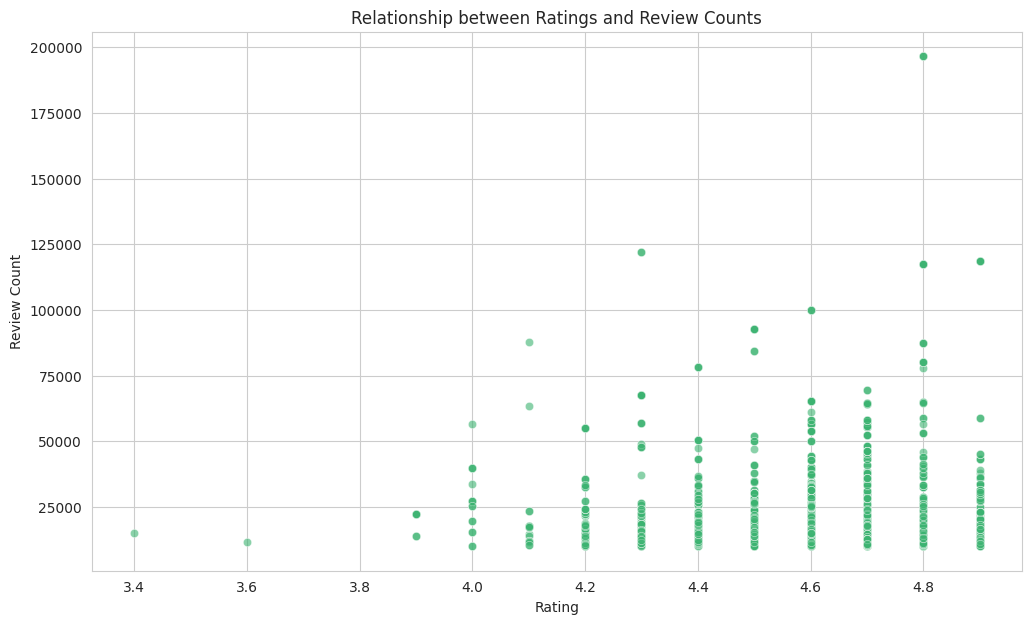

In [15]:
# Scatter plot to show the relationship between ratings and review counts
plt.figure(figsize=(12, 7))
sns.scatterplot(data=amazon_books_df, x='rating', y='reviews_count', alpha=0.6, color='mediumseagreen')
plt.title('Relationship between Ratings and Review Counts')
plt.xlabel('Rating')
plt.ylabel('Review Count')
plt.show()


# Phase 5: Interpretation/Evaluation

In this phase, we'll evaluate the insights obtained during the data mining phase and interpret their significance. We'll also attempt to answer any business or research questions and provide actionable insights.

From our analysis so far:

    Highly Rated Books: The majority of the books in this dataset are highly rated, with ratings between 4.5 and 5. This suggests that the dataset comprises popular books that are well-received by readers.

    Book Prices: Most books are priced between $10 and $20, with a few outliers priced significantly higher. This provides a general price range for popular books on Amazon.

    Relationship Between Ratings and Reviews: While there isn't a clear linear relationship between ratings and the number of reviews, books with higher ratings (between 4.5 and 5) tend to have a wider range of review counts. This suggests that a high rating doesn't necessarily guarantee a high number of reviews, but highly-rated books have the potential to attract a significant number of reviews.

    Delivery Options: Approximately 62% of the books offer free delivery, which might be a factor influencing their popularity.

Given these insights:

    For Authors/Publishers: Ensuring high-quality content can lead to better ratings, potentially attracting more reviews and increasing the book's visibility. Offering competitive prices (in the $10-$20 range) and free delivery can also make a book more appealing to potential readers.

    For Amazon: Since the majority of popular books offer free delivery, this feature can be highlighted in promotions to attract more buyers. Additionally, Amazon could consider promoting books with high ratings but fewer reviews to increase their visibility.

# Phase 6: Deployment

In a real-world scenario, this phase involves implementing the discovered knowledge into the organization's operations. The insights obtained can be used to drive business strategies, improve operations, or develop new products/services.

For our EDA:

    A detailed report summarizing the findings can be shared with stakeholders.
    If this analysis was part of a larger project (e.g., building a recommendation system), the insights could guide feature engineering and model selection.

Lastly, to facilitate easy deployment and sharing, we can encapsulate our analysis in a Jupyter notebook (as we've done here) or use tools like PyCaret to deploy models.